# Titanic dataset solution with Pandas, Numpy, and SK-Learn:

Leave notes on starting this notebook in a conda environment with correct dependencies.

Run this command to download the data:

In [1]:
!kaggle competitions download -c titanic

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 1.33MB/s]


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import zipfile

The data is now in a zip file in the same directory as our current working directory.

Reading in the data with pandas:

In [2]:
zip_file = zipfile.ZipFile('./titanic.zip')

dfs = {
text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
for text_file in zip_file.infolist()
    if text_file.filename.endswith('.csv')
}

# We know the three dataframes are named as follows:
df_gender = dfs['gender_submission.csv']
df_test = dfs['test.csv']
df_train = dfs['train.csv']

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Exploratory Data Analysis

- First, we'll see if there are any missing data in the training and test data
- Then, we'll try to see if there's any patterns with who survived to get an idea of what features are potentially important.

Below, we show the % of each feature that is missing in the data:

In [60]:
print("% of each feature missing in Training data:\n")
print(100 * df_train.isnull().sum() / len(df_train))

% of each feature missing in Training data:

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [61]:
print("% of each feature missing in Test data:\n")
print(100 * df_test.isnull().sum() / len(df_test))

% of each feature missing in Test data:

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


Note that in the **test** data, Fare has some missing values as well.

Now plotting features against Survived to see if there are any features that stand out. 

Below, we start with categorical features that we can easily plot: 
- Sex
- Pclass
- Embarked

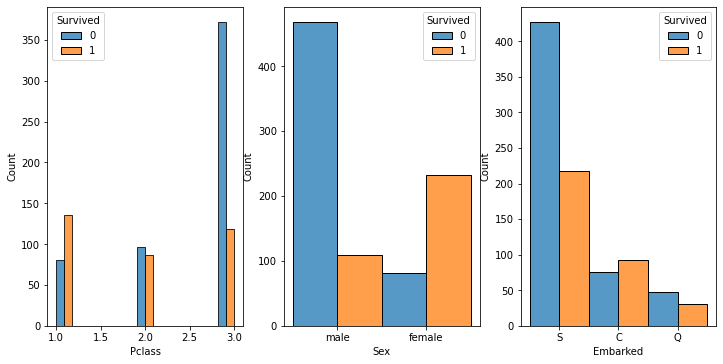

In [77]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
fig.tight_layout(pad=1.0)
# semicolons stop the annoying Output messages from Jupyter
sns.histplot(data=df_train, x="Pclass", hue="Survived", multiple="dodge", ax=ax[0]);
sns.histplot(data=df_train, x="Sex", hue="Survived", multiple="dodge", ax=ax[1]); 
sns.histplot(data=df_train, x="Embarked", hue="Survived", multiple="dodge", ax=ax[2]);

Note that both these features seem incredibly important in determining who survives. Specifically, Men seem to have survived significantly less and those with a Passenger class of 3.0 seem to have survived a lot less as well.

Carrying on with numerical features, we'll plot all of them against each other simultaneously (and include Survived since it is the target, even if it is not numerical):

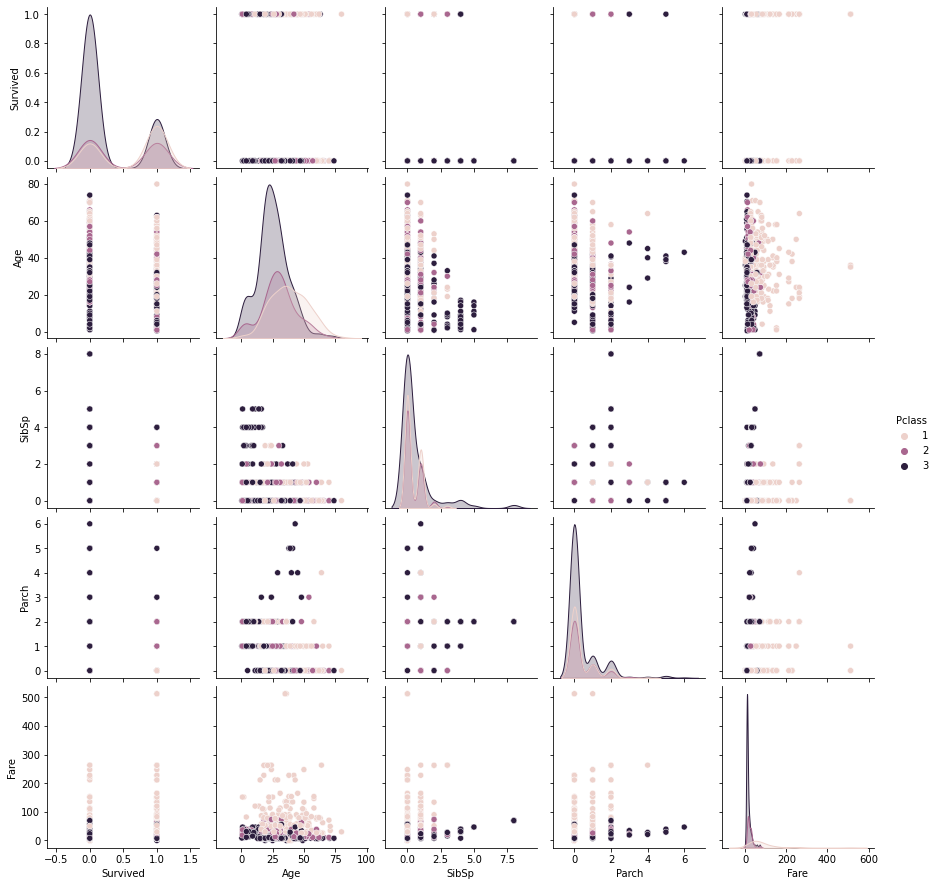

In [65]:
sns.pairplot(df_train.drop(columns=['PassengerId']), hue="Pclass");

Also plotting the heatmap:

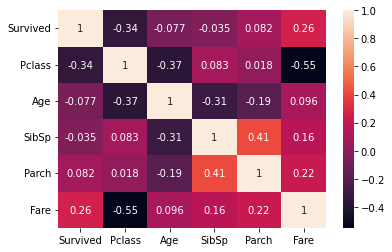

In [62]:
sns.heatmap(df_train.drop(columns='PassengerId').corr(), annot=True);

## Feature Engingeering

We'll be engineering features from old ones. Specifically, we'll engineer a feature based on the Cabin number.

## Preprocessing

Steps we'll take to preprocess:
- Drop irrelevant columns (PassengerId, Name, Ticket)
- Impute ages (we were missing some ages in the training and test data -- we'll simply impute the median age)
- Impute missing Fare based on Pclass (Pclass 3 = 25th Percentile, Pclass 2 = median, Pclass 1 = 75th Percentile)

### Pipeline components:

In [4]:
class Dropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

In [20]:
class Imputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="median")
        X['Age'] = imputer.fit_transform(X[['Age']])
        X['Fare'] = imputer.fit_transform(X[['Fare']])
        
        X['Embarked'] = X['Embarked'].fillna('S')
        return X

In [6]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # One-hot encodings:
        # Note that we'll have to drop the categorical cols at the end
        
        # Encoding Sex:
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        # Encoding Female into a one-hot vector
        X[encoder.categories_[0][0]] = matrix[:, 0]
        
        # Encoding Pclass:
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Pclass']]).toarray()
        # Encoding Pclass 1 and 2 into one-hot vectors
        for idx, col in enumerate(encoder.categories_[0][:-1]):
            X["Pclass" + str(col)] = matrix[:, idx]
            
        # Encoding Embarked:
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        # Encoding Pclass 1 and 2 into one-hot vectors
        for idx, col in enumerate(encoder.categories_[0][:-1]):
            X[col] = matrix[:, idx]
            
        return X.drop(columns=['Sex', 'Pclass', 'Embarked'])

In [7]:
class Scaler(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        scaler = StandardScaler()
        X['Age'] = scaler.fit_transform(X[['Age']])
        
        X['Fare'] = scaler.fit_transform(X[['Fare']])
        return X

In [33]:
pipe = Pipeline([
    ("dropper", Dropper()),
    ("imputer", Imputer()),
    ("feature_encoder", FeatureEncoder()),
    ("scaler", Scaler())
])

## Modelling and Validation

Before we do anything, we'll split the training data into a training set and a test set (leaving out an arbitrary *20%* from the training data).

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_train_preprocessed.drop(columns=['Survived']), df_train_preprocessed['Survived'], test_size=0.2, random_state=5)

In [35]:
X_train

,Age,SibSp,Parch,Fare,female,Pclass1,Pclass2,C,Q
887,-0.796286,0,0,-0.044381,1.0,1.0,0.0,0.0,0.0
416,0.356462,1,1,0.005956,1.0,0.0,1.0,0.0,0.0
479,-2.102733,0,1,-0.401017,1.0,0.0,0.0,0.0,0.0
134,-0.335187,0,0,-0.386671,0.0,0.0,1.0,0.0,0.0
588,-0.565736,0,0,-0.486337,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
400,0.740711,0,0,-0.488854,0.0,0.0,0.0,0.0,0.0
118,-0.412037,0,1,4.335332,0.0,1.0,0.0,1.0,0.0
701,0.433312,0,0,-0.119131,0.0,1.0,0.0,0.0,0.0
206,0.202762,1,0,-0.329287,0.0,0.0,0.0,0.0,0.0


### Computing a baseline:

We'll use a logistic regression model to estimate a baseline performance on these data.

In [36]:
baseline = LogisticRegression()
baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

0.8268156424581006

Our baseline achieves 82.7% on the hold out test data. We'll go about improving that through trying different models and hyperparameter tuning.

### Hyperparameter Tuning and trying other models:

#### Logistic Regression:

In [75]:
clf = LogisticRegression()

param_grid = [{
    "C": np.linspace(0.5, 5.0, 10)
}]
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)
clf_best = grid_search.best_estimator_

In [93]:
df_test_preprocessed

,Age,SibSp,Parch,Fare,female,Pclass1,Pclass2,C,Q
0,0.386231,0,0,-0.497413,0.0,0.0,0.0,0.0,1.0
1,1.371370,1,0,-0.512278,1.0,0.0,0.0,0.0,0.0
2,2.553537,0,0,-0.464100,0.0,0.0,1.0,0.0,1.0
3,-0.204852,0,0,-0.482475,0.0,0.0,0.0,0.0,0.0
4,-0.598908,1,1,-0.417492,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
413,-0.204852,0,0,-0.493455,0.0,0.0,0.0,0.0,0.0
414,0.740881,0,0,1.314435,1.0,1.0,0.0,1.0,0.0
415,0.701476,0,0,-0.507796,0.0,0.0,0.0,0.0,0.0
416,-0.204852,0,0,-0.493455,0.0,0.0,0.0,0.0,0.0


In [95]:
df_submission = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': clf_best.predict(df_test_preprocessed)
})

In [106]:
df_submission.to_csv('submission.csv', index=False)

In [101]:
df_test = pd.read_csv('submission.csv')